In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
import nltk
# For text analysis
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from PIL import Image
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
import cycler
import seaborn as sns

In [ ]:
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters


sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

# Introduction

Throughout this part we will analyze the text from the reviews the customers have given to the purchased products.
In the first part we will do a topic analysis using LDA in order to investigate what are the main topics hidden in the reviews. We aim to get an understanding about customers' satisfaction as well as Olist customer service performance.

In the second part we will perform sentiment analysis on the reviews. The purpose of sentiment analysis is to predict the review score in cases that a customer has provided a comment but hasn't given a score. By predicting the review scores when they are missing will help Olist to get better understanding for products quality and overall service.

**Note**

The translated text for the reviews provided by a fellow student

## Text analysis

In [ ]:
#import data
data=pd.read_excel('/content/drive/MyDrive/AdvancedBA/Olie_data/olist_reviews_with_translation.xlsx')
data.head()

,Unnamed: 0,review_id,order_id,review_score,review_comment_title,review_comment_title_translated,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_message_translated
0,0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,NaN
1,1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,NaN
2,2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,NaN
3,3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,I received it well before the stipulated deadl...
4,4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,Congratulations lannister stores loved shoppin...


From previous analysis we saw that the reviews had a huge amount of NaN values

In [ ]:
#drop all columns with NaN values
data.dropna(inplace=True)

In [ ]:
#check for duplicates
pd.concat(g for _, g in data.groupby("review_comment_message_translated") if len(g) > 1)

,Unnamed: 0,review_id,order_id,review_score,review_comment_title,review_comment_title_translated,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_message_translated
38675,38675,e2e44e3eeaa2d29e879b35578df28569,ec864a967206dcb874a7db0ffa6fb17d,5,0,False,0,2018-04-28 00:00:00,2018-05-03 13:09:43,0
52882,52882,22da30dde9db9742eef832df2e82018c,adddc7adab7516dd578d700024245d43,1,00,False,00,2018-07-26 00:00:00,2018-07-30 21:44:40,0
19638,19638,ff9c1c1c60e0d0d8357dcfddd5d30c74,eb7d3683f623a9aa24ed0e4fa4a84c2e,5,10,10,10,2018-07-27 00:00:00,2018-07-27 23:09:39,10
19724,19724,282bc4139e6dc1b0065e4508483df6f8,6447ac90fec2245143232faee2c1728b,5,10,10,10,2018-05-11 00:00:00,2018-05-23 11:11:39,10
23391,23391,72bfa12277357444b874425ec8565963,5cd8853b4ec297e801336f317f9a1912,5,10,10,10,2018-06-26 00:00:00,2018-06-28 17:23:16,10
...,...,...,...,...,...,...,...,...,...,...
90947,90947,e9e81e73f44a0fc9212369c351f9d08b,9a06f6b071c10b11ce8e6e8646dae224,4,otimo,excellent,bom,2018-06-20 00:00:00,2018-06-21 19:04:47,well
95708,95708,352309d398caa4ec54b8b2b1344e39f7,e73e3170000c0a93c0470e40aa0ccf91,4,bOM,well,bOM,2018-06-21 00:00:00,2018-06-21 18:52:18,well
98720,98720,4df691d52d86e49573b02595c6cca3ac,0c2c69625643d98afb22fc2e8dea27ba,4,bom,well,bom,2018-05-18 00:00:00,2018-05-20 23:47:29,well
15106,15106,45b2ed2edcd0290b079318d568578f04,2d30bcdaaf18c2598140aa6f7f230216,4,xx,xx,xx,2018-06-14 00:00:00,2018-06-18 11:31:28,xx


In [ ]:
# dropping ALL duplicte values
data.drop_duplicates(subset ="review_comment_message_translated",
                     keep = False, inplace = True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8592 entries, 9 to 99975
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Unnamed: 0                         8592 non-null   int64 
 1   review_id                          8592 non-null   object
 2   order_id                           8592 non-null   object
 3   review_score                       8592 non-null   int64 
 4   review_comment_title               8592 non-null   object
 5   review_comment_title_translated    8592 non-null   object
 6   review_comment_message             8592 non-null   object
 7   review_creation_date               8592 non-null   object
 8   review_answer_timestamp            8592 non-null   object
 9   review_comment_message_translated  8592 non-null   object
dtypes: int64(2), object(8)
memory usage: 738.4+ KB


In [ ]:
#keep only the text columns
text = data[['review_comment_title_translated','review_comment_message_translated']]
text

,review_comment_title_translated,review_comment_message_translated
9,I recommend,efficient device. on the website the brand of ...
15,Super recommend,"Reliable seller, ok product and delivery befor..."
19,My product did not arrive,Terrible
34,Very good.,I got exactly what I expected. Other orders fr...
36,Well,"I recommend ,"
...,...,...
99962,Full mark!,"Thank you very much Excellent service, barathe..."
99967,👍,Approved!
99971,very good product,"We were very satisfied with the product, it me..."
99972,The order was not delivered,"Good morning Of the 6 units purchased, I only ..."


### Text Cleaning

In [ ]:
lemmatizer = WordNetLemmatizer()
STOPWORDS = nltk.corpus.stopwords.words('english')


def text_processing(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r'\b\w\b', ' ', text)
    text = re.sub('@[^\s]+','',text)
    text = emoji_pattern.sub(r'', text)
    # remove punctuation 
    text = "".join([c for c in text if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # remove stopwords
    text = " ".join([w for w in text.split()  if w not in STOPWORDS])
    # stemming / lematizing (optional)
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text

In [ ]:
text_processing_vec = np.vectorize(text_processing)
text['clean_review_comment'] = text['review_comment_message_translated'].astype(str).apply(text_processing_vec)
text['clean_review_title'] = text['review_comment_title_translated'].astype(str).apply(text_processing_vec)

In [ ]:
text.head(10)

,review_comment_title_translated,review_comment_message_translated,clean_review_comment,clean_review_title
9,I recommend,efficient device. on the website the brand of ...,efficient device website brand device printed ...,recommend
15,Super recommend,"Reliable seller, ok product and delivery befor...",reliable seller ok product delivery deadline,super recommend
19,My product did not arrive,Terrible,terrible,product arrive
34,Very good.,I got exactly what I expected. Other orders fr...,got exactly expected order seller delayed one ...,good
36,Well,"I recommend ,",recommend,well
38,Amazing!,"I'm completely in love, super responsible and ...",im completely love super responsible reliable ...,amazing
43,Perfect delivery,Very good. very fragrant.,good fragrant,perfect delivery
67,Great Product!,I recommend the seller ...,recommend seller,great product
79,I ALWAYS RECOMMEND !!,The canine patrol backpack kit is beautiful !!...,canine patrol backpack kit beautiful little gr...,always recommend
108,EXCELLENT,OK I RECOMMEND,ok recommend,excellent


In [ ]:
def get_top_n_words(corpus, n=None):

    ''' Function that return the top uni-grams'''

    corpus = [str (item) for item in corpus]
    corpus = [item for item in corpus if not isinstance(item, int)]
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):

    ''' Function that returns the top bi-grams'''

    corpus = [str (item) for item in corpus]
    corpus = [item for item in corpus if not isinstance(item, int)]
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_trigram(corpus, n=None):

    ''' Function that returns the top tri-grams'''
    
    corpus = [str (item) for item in corpus]
    corpus = [item for item in corpus if not isinstance(item, int)]
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


### Text summary

Below we illustrate what are the most common words appear before and after cleaning in comment and title review section.

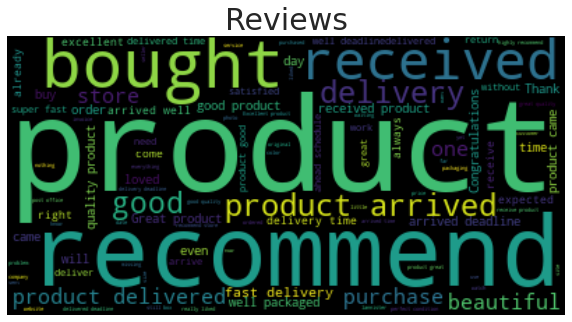

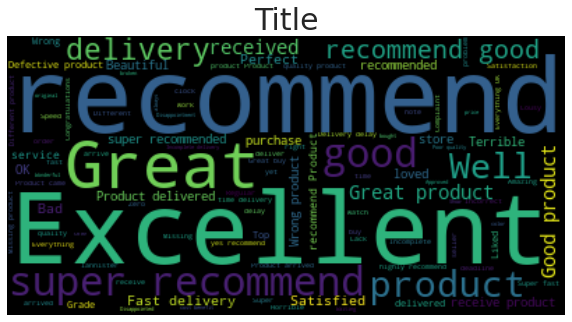

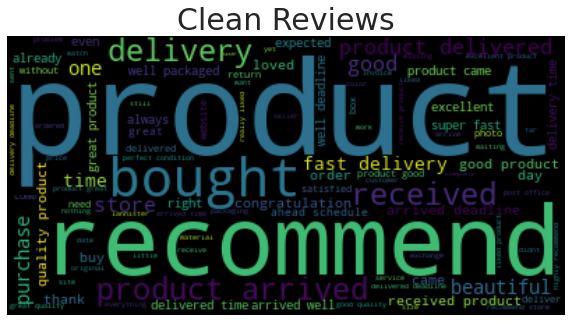

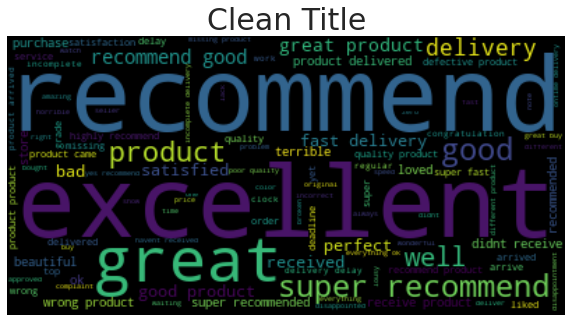

In [ ]:
def show_wordcloud(df, title):

    if title=="Clean Reviews":
      text = ' '.join(df['clean_review_comment'].astype(str).tolist())
    elif title=='Clean Title':
      text = ' '.join(df['clean_review_title'].astype(str).tolist())
    elif title=="Reviews":
      text = ' '.join(df['review_comment_message_translated'].astype(str).tolist())
    elif title=='Title':
      text = ' '.join(df['review_comment_title_translated'].astype(str).tolist())

    stopwords = set(wordcloud.STOPWORDS)
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,max_font_size=100, max_words=100, background_color="black").generate(text)
    
    plt.figure(figsize=(10,10), frameon=True)
    plt.imshow(fig_wordcloud, interpolation="bilinear")  
    plt.axis('off')
    plt.title(title, fontsize=30)
    plt.show()

show_wordcloud(text, "Reviews")
show_wordcloud(text, "Title")
show_wordcloud(text, "Clean Reviews")
show_wordcloud(text, "Clean Title")

On the first sight it seems that both titles and comments refer to positive reviews.
Below we will do a bit more in depth analysis on the words appear the most. We will illustrate the top uni,bi and tri-grams.

### Uni-gram illustration

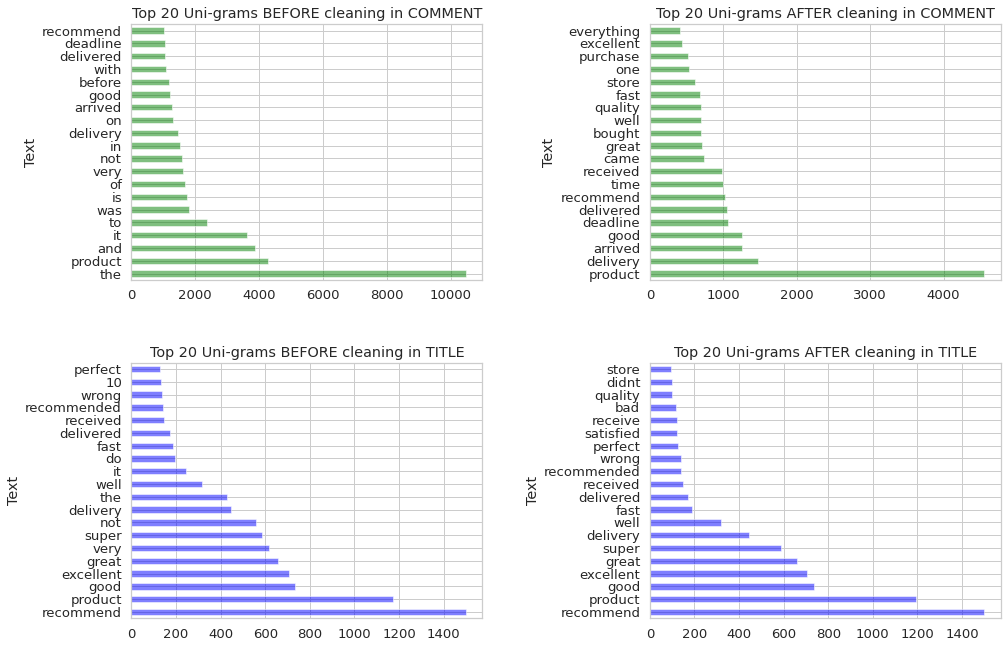

In [ ]:
#Plot the top 20 uni-grams for both clean and not-clean text
common_words_message = get_top_n_words(text['review_comment_message_translated'], 20)
common_words_title = get_top_n_words(text['review_comment_title_translated'], 20)
common_words_message_clean = get_top_n_words(text['clean_review_comment'], 20)
common_words_title_clean = get_top_n_words(text['clean_review_title'], 20)

df1 = pd.DataFrame(common_words_message, columns = ['Text' , 'count'])
df2 = pd.DataFrame(common_words_title, columns = ['Text' , 'count'])
df1_clean = pd.DataFrame(common_words_message_clean, columns = ['Text' , 'count'])
df2_clean = pd.DataFrame(common_words_title_clean, columns = ['Text' , 'count'])


fig, axes = plt.subplots(nrows=2,ncols = 2 , sharey=False,figsize=(15,10))
#plt.figure(figsize=(15,10))
df1.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Uni-grams BEFORE cleaning in COMMENT',
                                                                     alpha=0.5,
                                                                     facecolor='Green', ax=axes[0,0])
df2.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Uni-grams BEFORE cleaning in TITLE',
                                                                     alpha=0.5,
                                                                  facecolor='Blue', ax=axes[1,0])
df1_clean.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Uni-grams AFTER cleaning in COMMENT',
                                                                     alpha=0.5,
                                                                     facecolor='Green', ax=axes[0,1])
df2_clean.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Uni-grams AFTER cleaning in TITLE',
                                                                     alpha=0.5,
                                                                  facecolor='Blue', ax=axes[1,1])


fig.tight_layout(pad=3)
plt.show()

Above we can see what are the top 20 words that appear the most in review title(purple) and review comments (green). 
Clearly in comment section where we have longer sentences the so called stopwards appear the most. After cleaning the text it's more clear what are the most frequent words. 

On the other hand in review titles stopwords don't appear often as the length of sentences is shorter that in the reviews.
We can see in titles (clean) there are words such as wrong and bad which indicate a bad review. However, in comment section we don't observe such a words.

In order to make it more clear we will try to illustrate the most frequent bi-grams.

### Bi-gram illustration

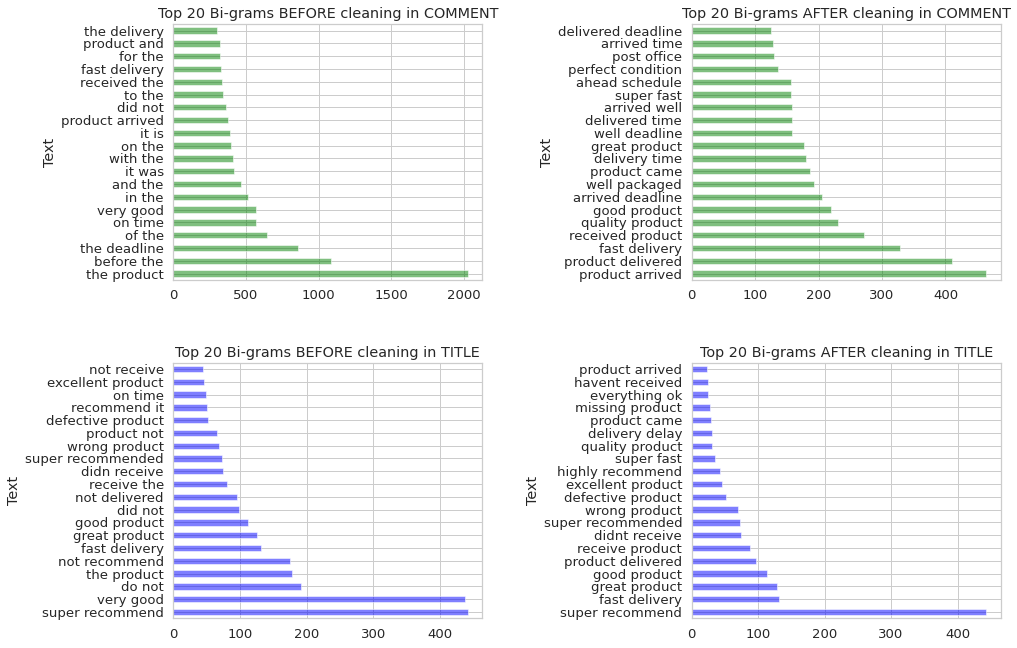

In [ ]:
common_words_message = get_top_n_bigram(text['review_comment_message_translated'], 20)
common_words_title = get_top_n_bigram(text['review_comment_title_translated'], 20)
common_words_message_clean = get_top_n_bigram(text['clean_review_comment'], 20)
common_words_title_clean = get_top_n_bigram(text['clean_review_title'], 20)



df1 = pd.DataFrame(common_words_message, columns = ['Text' , 'count'])
df2 = pd.DataFrame(common_words_title, columns = ['Text' , 'count'])
df1_clean = pd.DataFrame(common_words_message_clean, columns = ['Text' , 'count'])
df2_clean = pd.DataFrame(common_words_title_clean, columns = ['Text' , 'count'])


fig, axes = plt.subplots(nrows=2,ncols = 2 , sharey=False,figsize=(15,10))
#plt.figure(figsize=(15,10))
df1.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Bi-grams BEFORE cleaning in COMMENT',
                                                                     alpha=0.5,
                                                                     facecolor='Green', ax=axes[0,0])
df2.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Bi-grams BEFORE cleaning in TITLE',
                                                                     alpha=0.5,
                                                                  facecolor='Blue', ax=axes[1,0])
df1_clean.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Bi-grams AFTER cleaning in COMMENT',
                                                                     alpha=0.5,
                                                                     facecolor='Green', ax=axes[0,1])
df2_clean.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Bi-grams AFTER cleaning in TITLE',
                                                                     alpha=0.5,
                                                                  facecolor='Blue', ax=axes[1,1])


fig.tight_layout(pad=3)
plt.show()

By analysing the most frequent bi-grams we still observe that in the commnet section (top-right) tend to refer to a positive feedback.
However, in title (bottom-right) there are mixed frequent bi-grams.

### Tri-gram illustration

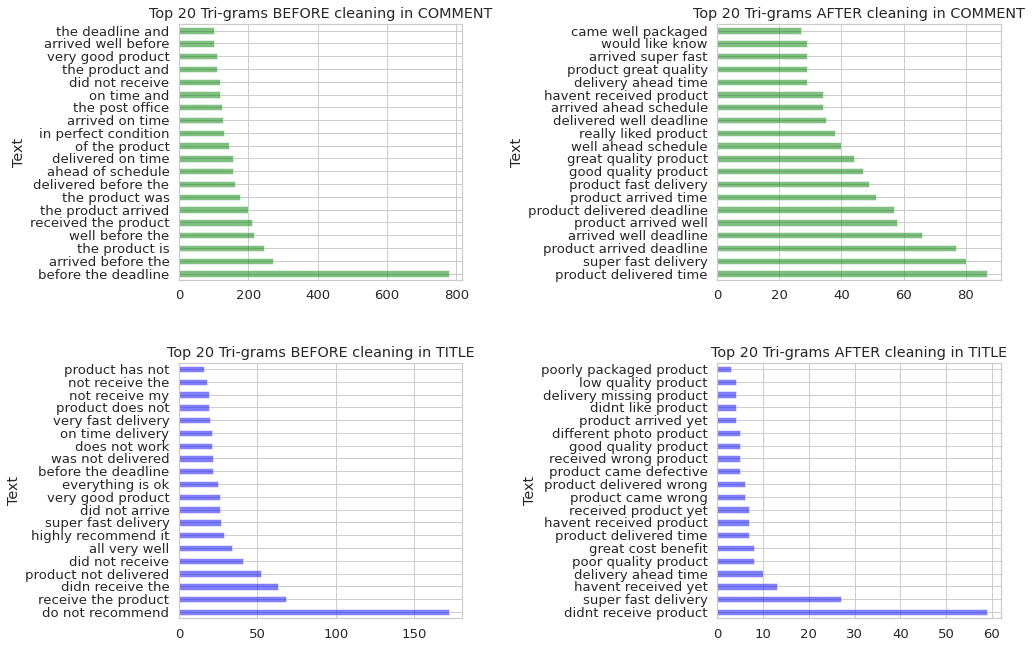

In [ ]:
common_words_message = get_top_n_trigram(text['review_comment_message_translated'], 20)
common_words_title = get_top_n_trigram(text['review_comment_title_translated'], 20)
common_words_message_clean = get_top_n_trigram(text['clean_review_comment'], 20)
common_words_title_clean = get_top_n_trigram(text['clean_review_title'], 20)


df1 = pd.DataFrame(common_words_message, columns = ['Text' , 'count'])
df2 = pd.DataFrame(common_words_title, columns = ['Text' , 'count'])
df1_clean = pd.DataFrame(common_words_message_clean, columns = ['Text' , 'count'])
df2_clean = pd.DataFrame(common_words_title_clean, columns = ['Text' , 'count'])


fig, axes = plt.subplots(nrows=2,ncols = 2 , sharey=False,figsize=(15,10))
#plt.figure(figsize=(15,10))
df1.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Tri-grams BEFORE cleaning in COMMENT',
                                                                     alpha=0.5,
                                                                     facecolor='Green', ax=axes[0,0])
df2.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Tri-grams BEFORE cleaning in TITLE',
                                                                     alpha=0.5,
                                                                  facecolor='Blue', ax=axes[1,0])
df1_clean.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Tri-grams AFTER cleaning in COMMENT',
                                                                     alpha=0.5,
                                                                     facecolor='Green', ax=axes[0,1])
df2_clean.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Tri-grams AFTER cleaning in TITLE',
                                                                     alpha=0.5,
                                                                  facecolor='Blue', ax=axes[1,1])


fig.tight_layout(pad=3)
plt.show()


Using tri-grams in order to add better understand what appears the most both in title and comment section. We observe again a discrepancy between titles and comments. Comments overall seem to refer to a positive feedback while in title the opposite.

## Topic modelling with LDA

In order to better understand the topics hidden in the reviews we will perform an topic modelling with LDA

In [ ]:
# Vectorize reviews comments

vectorizer_comments = CountVectorizer(ngram_range=(2, 2))
bow_counts_comments = vectorizer_comments.fit_transform(text['clean_review_comment'].values)


vectorizer_title = CountVectorizer()
bow_counts_title = vectorizer_title.fit_transform(text['clean_review_title'].values)
# print(bow_counts_comments[0])
# print(vectorizer_comments.get_feature_names())
print('Vectorizer Comments',len(vectorizer_comments.vocabulary_))
print('Vectorizer Title',len(vectorizer_title.vocabulary_))


Vectorizer Comments 30038
Vectorizer Title 1413


In [ ]:

# empty model
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
comments_lda = lda.fit_transform(bow_counts_comments)
titles_lda = lda.fit_transform(bow_counts_title)

In [ ]:
# Function that prints n top words
# Ref: Course's Notebook text Analysis - Part 1 - Spam Classification-solutions
def print_top_words(model, feature_names, n_top_words):
    norm = model.components_.sum(axis=1)[:, np.newaxis]
    for topic_idx, topic in enumerate(model.components_):
        print(80 * "-")
        print("Topic {}".format(topic_idx))
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            print("{:.3f}".format(topic[i] / norm[topic_idx][0]) 
                  + '\t' + feature_names[i])

In [ ]:
print("\nTopics in Comments LDA model:")
counts_feature_names = vectorizer_comments.get_feature_names()
n_top_words = 10
print_top_words(lda, counts_feature_names, n_top_words)


Topics in Comments LDA model:
--------------------------------------------------------------------------------
Topic 0
0.278	agreed right
0.119	arrive product
0.043	according note
0.037	appeared lost
0.030	according review
0.028	already ripped
0.017	adhesive tape
0.012	arrived baseus
0.011	arrive ordered
0.011	another site
--------------------------------------------------------------------------------
Topic 1
0.356	announced baratheon
0.054	admirable service
0.039	arrived almost
0.032	another cover
0.026	approve blocking
0.024	always improve
0.022	also nothing
0.021	accordance instruction
0.019	almost perfect
0.019	adjustable strap
--------------------------------------------------------------------------------
Topic 2
0.253	affordable physical
0.241	agreed well
0.043	anymore already
0.023	announcement received
0.019	anything await
0.018	already made
0.016	actually common
0.011	administrator cancel
0.010	anxious product
0.009	also longer
----------------------------------------------

From the topic modelling in comment section it's not very clear what kind of different topics are created. It seems that all of them are somehow related.

In [ ]:
print("\nTopics in Title LDA model:")
counts_feature_names = vectorizer_title.get_feature_names()
n_top_words = 10
print_top_words(lda, counts_feature_names, n_top_words)


Topics in Title LDA model:
--------------------------------------------------------------------------------
Topic 0
0.278	good
0.119	well
0.043	bad
0.037	store
0.030	beautiful
0.028	loved
0.017	deadline
0.012	yes
0.011	watch
0.011	regular
--------------------------------------------------------------------------------
Topic 1
0.356	product
0.054	delivered
0.039	wrong
0.032	received
0.026	terrible
0.024	order
0.022	missing
0.021	arrived
0.019	incomplete
0.019	defective
--------------------------------------------------------------------------------
Topic 2
0.253	excellent
0.241	great
0.043	satisfied
0.023	purchase
0.019	service
0.018	liked
0.016	buy
0.011	deliver
0.010	satisfaction
0.009	misleading
--------------------------------------------------------------------------------
Topic 3
0.445	recommend
0.140	super
0.036	receive
0.030	quality
0.028	didnt
0.020	delay
0.015	yet
0.015	highly
0.012	different
0.010	received
---------------------------------------------------------------------

From topic modelling on the titles we can make better conclusion on the topics. For example topic 1 depicts reviews about the product and whether deliver in good or bad condition. We can see words such as delivered wrong, incomplete, terrible.
In topice 4 however we can see that refers to delivery in general. Here words such as fast and perfect appear indicating that the delivery performance is good.

# Sentiment Analysis


After generating the topics for each review titles and review comments our group performed a sentiment analysis. The sentiment analysis was based on the the data from *Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter  (Dataset S1)*.

In [ ]:
happinessDf = pd.read_csv('/content/drive/MyDrive/AdvancedBA/Olie_data/happylist.csv','\t')
happinessDf.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


In [ ]:
def Sentiment(liste):
    value=[]
    sums=[]
    list1=dict(nltk.FreqDist(liste)) #Find the frequency of the words
    for word in list1.keys():
        if word in list(happinessDf['word']): # Check if word is in the dataset
            c=happinessDf['happiness_average'][list(happinessDf['word']).index(word)]*list1[word] #Find the happiness_average value
            value.append(c) # Save the happiness_average value
            sums.append(list1[word]) # Save the frequncy of the words 
    if len(value)>0: 
        return sum(value)/sum(sums) # Sentiment score
    else:
        return 0

In [ ]:
clean_reviews = list(text["clean_review_comment"].values)
sentiment_scores=[]
for indx,i in enumerate(clean_reviews):
    sentiment_scores.append(Sentiment(i))

In [ ]:
Reviews_scores = pd.DataFrame(
    {'Review': clean_reviews,
     'Sentiment Score': sentiment_scores
    })

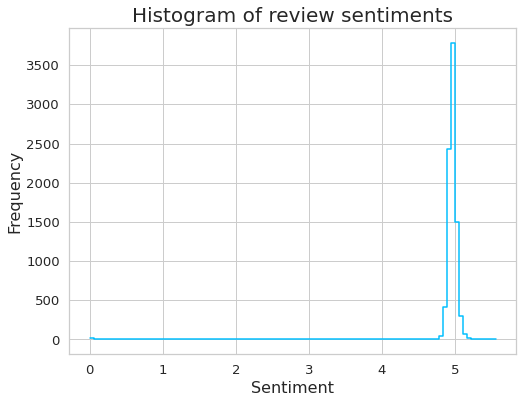

In [ ]:
hist, bins = np.histogram(sentiment_scores, bins = 100)

plt.figure(figsize=(8,6))
plt.plot(bins, np.insert(hist, 0, hist[0]), drawstyle='steps')
plt.title("Histogram of review sentiments", size=20)
plt.xlabel("Sentiment",size=16)
plt.ylabel("Frequency",size=16)
plt.show()

We can see from the histogram that most reviews score between 4.5 to 5.5 and there is some reviews with a sentiment of 0. This means that the review does not contain any words from the happiness dataset.

#Conclusion

The topic analysis revealed that the titles are more approriate to categorize reviews into specific topics. The fact that the titles are short and direct sentences gives better understanding about the review on the contrary to the comment. As a future step we could use LDA to predict in what topic each of the comment reviews falls in.

The sentiment analysis reveals that most of the reviews are favorable but not in the top sentient category. A further indepth anaæysis of review sentiments could reveal why this is and help the company improve the product.